In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

from functools import partial

### Import MNIST data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### function to save variable summaries for tensorboard

In [3]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### set parameters

In [4]:
learning_rate = 0.001

training_epochs = 1
batch_size = 200
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 28 * 28
n_hidden_1 = 500
n_hidden_2 = 500
n_hidden_coding = 20  # codings

# log directory for tensorboard
log_dir = '/tmp/tensorflow/variational_autoencoder/logs'

In [5]:
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])

### 標準セットのlayerを定義する

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [6]:
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg = 0.0):
    with tf.variable_scope(name):
        
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        #l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init)
        
        layer_vars = layer.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

### decoder部

In [7]:
def encoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='encoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_2, name='encoder_2')
    return layer_2

### coding space

In [8]:
def coding_space(x):
    coding_mean = nn_layer(x, n_hidden_coding, name='coding_mean', activation=None)
    coding_sigma = nn_layer(x, n_hidden_coding, name='coding_sigma', activation=None)
    noise = tf.random_normal(tf.shape(coding_sigma), dtype=tf.float32)
    layer = coding_mean + coding_sigma * noise
    return layer, coding_mean, coding_sigma

### encoder部

In [9]:
def decoder(x):
    layer_1 = nn_layer(x, n_hidden_2, name='decoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_1, name='decoder_2')
    layer_3 = nn_layer(layer_2, n_input, name='decoder_3', activation=None)
    return layer_3

### Reset Graph

In [12]:
tf.reset_default_graph()

### グラフを定義

コスト関数：シグモイド＆クロスエントロピー誤差を用いてロス値を計算する方法

In [13]:
# Construct model
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])
    
with tf.variable_scope('encoder_part'):
    encoder_op = encoder(X)
    
with tf.variable_scope('coding_part'):
    coding_op, coding_mean, coding_sigma = coding_space(encoder_op)

with tf.variable_scope('decoder_part'):
    decoder_op = decoder(coding_op)

# Prediction
with tf.variable_scope('prediction'):
    y_pred = tf.nn.sigmoid(decoder_op)

# Targets (Labels) are the input data.
with tf.variable_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.variable_scope('reconstruction_loss'):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)
    reconstruction_loss = tf.reduce_sum(xentropy)

with tf.variable_scope('latent_loss'):
    eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
    latent_loss = 0.5 * tf.reduce_sum(
        tf.square(coding_sigma) + tf.square(coding_mean)
        - 1 - tf.log(eps + tf.square(coding_sigma)))
    
with tf.variable_scope('cost'):
    cost = reconstruction_loss + latent_loss
    
tf.summary.scalar('reduce_mean', cost)


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


### Training

Epoch: 0001 cost= 43329.640625000
Optimization Finished!


/Users/shinya/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


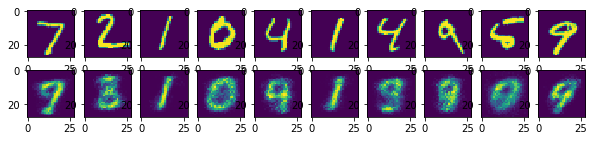

In [14]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

saver = tf.train.Saver()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')

    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) adn cost op (to get loss value)
            summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            sys.stdout.flush()
        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()
    saver.save(sess, log_dir + "model/my_model")

    # Applying encode and decode over test set
    encode_decode = sess.run(y_pred,
                             feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()

sess.close()

## クラスタリング

中間層の出力をTensorboardでクラスタリングしてみます。

In [15]:
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [16]:
n_data = 10000

#init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    batch_xs, batch_ys = mnist.test.next_batch(n_data)
    hidden = sess.run(coding_op, feed_dict={X: batch_xs})
    hidden_mean = sess.run(coding_mean, feed_dict={X: batch_xs})

INFO:tensorflow:Restoring parameters from /tmp/tensorflow/variational_autoencoder/logsmodel/my_model


In [17]:
hidden_mean

array([[-0.70602584,  1.32465982, -0.47980461, ..., -1.55300546,
         0.25150165,  0.6377182 ],
       [ 1.21388507, -2.45915437, -0.82980567, ..., -0.44436219,
         0.08918467, -1.84169734],
       [ 1.24605751,  0.46044445,  0.08543535, ..., -0.54511666,
         0.59415621, -2.06311393],
       ..., 
       [ 0.52962732, -1.67235136, -1.59014583, ..., -0.46323103,
        -0.35690278, -0.95665246],
       [-0.68312097,  1.18388963,  0.81438488, ...,  1.88407314,
        -1.66737843,  1.05469429],
       [ 0.15267199,  1.60975933,  1.84754837, ..., -0.03101728,
         0.25121298, -0.73038304]], dtype=float32)

### メタデータファイルの作成

In [18]:
# 
#LOG_DIR = "/tmp/tensorflow/variational_AE_MNIST/logs"

# recreate log directory
if tf.gfile.Exists(log_dir + '/projector'):
    tf.gfile.DeleteRecursively(log_dir + '/projector')
tf.gfile.MakeDirs(log_dir + '/projector')

In [19]:
ys = batch_ys
with open(os.path.join(log_dir, 'projector/metadata.tsv'),'w') as f:
    #f.write("Index\tLabel\n")
    for index, label in enumerate(ys):
        label = int(np.where(label == 1)[0])   ## one-hot to index
        f.write('{}\n'.format(label))

### クラスタ用のembeddingを保存

In [20]:
xs = tf.stack(hidden_mean, axis=0)

with tf.variable_scope('hidden_embedding'):
    embedding_var = tf.Variable(xs, trainable=False, name='embedding')


summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'projector'), sess.graph)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# metadata 
embedding.metadata_path = os.path.join(log_dir, 'projector/metadata.tsv')

# stripe 
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
#embedding.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(summary_writer, config)


#sess = tf.InteractiveSession()

# initialize "embedding_ver"
init = tf.variables_initializer([embedding_var])

with tf.Session() as sess:
    sess.run(init)
    # specify variable to save 
    saver = tf.train.Saver([embedding_var])
    # save variables 
    saver.save(sess, os.path.join(log_dir, "projector/model.ckpt"), global_step=n_data)

## Generate digits

In [21]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

with tf.Session() as sess:
    init.run()
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()  
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={X: X_batch})
        summary, loss_val, reconstruction_loss_val, latent_loss_val = sess.run([merged, cost, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) 
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown    
        train_writer.add_summary(summary, epoch)
        
        codings_rnd = np.random.normal(size=[n_digits, n_hidden_coding])
        outputs_val = y_pred.eval(feed_dict={coding_op: codings_rnd})
        
    train_writer.close()
    test_writer.close()

0 Train total loss: 33773.5 	Reconstruction loss: 25171.8 	Latent loss: 8601.7
1 Train total loss: 28732.8 	Reconstruction loss: 22795.9 	Latent loss: 5936.88
15%

KeyboardInterrupt: 

In [14]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

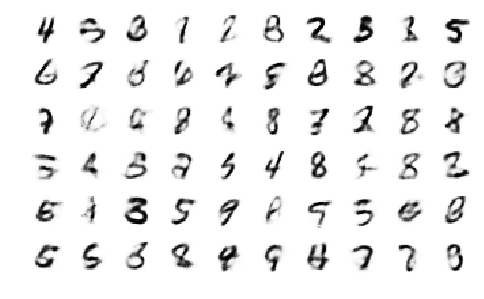

In [15]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])